In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam

%pip install keras-tuner -q
from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters

Note: you may need to restart the kernel to use updated packages.


C:\Users\pande\AppData\Local\Temp\ipykernel_12780\3881830930.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [4]:
assets = {
    # Stocks
    'TCS': 'nse/TCS.csv',
    'Reliance': 'nse/RELIANCE.csv',
    'HDFCBANK': 'nse/HDFCBANK.csv',
    # Indices
    'NIFTY_50': 'indices/NIFTY_50.csv',
    'NIFTY_500': 'indices/NIFTY_500.csv',
    'NIFTY_Bank': 'indices/NIFTY_Bank.csv',
    'NIFTY_FMCG': 'indices/NIFTY_FMCG.csv',
    'NIFTY_IT': 'indices/NIFTY_IT.csv',
    'NIFTY_Midcap_100': 'indices/NIFTY_Midcap_100.csv'
}


In [5]:
data_dict = {}
for name, filepath in assets.items():
    # Read the file by skipping the first two rows and assign new column names.
    df = pd.read_csv(filepath, skiprows=2, 
                     names=['Date', 'Close', 'High', 'Low', 'Open', 'Volume'])
    
    # Remove rows where the 'Date' column still contains the string 'Date'
    df = df[df['Date'] != 'Date']
    
    # Convert the 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort and set the Date as index, then drop any remaining missing values
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    df = df.dropna()
    
    data_dict[name] = df

# Example: Display summary statistics for Reliance
print("Reliance Data Summary:")
print(data_dict['Reliance'].describe())


Reliance Data Summary:
             Close         High          Low         Open        Volume
count  7337.000000  7337.000000  7337.000000  7337.000000  7.337000e+03
mean    314.224735   317.924989   310.805427   314.489836  5.930476e+07
std     403.569002   407.599832   399.851843   403.844282  1.019855e+08
min       2.952742     2.952742     2.921043     2.939293  0.000000e+00
25%      17.672050    18.010303    17.464538    17.710134  1.365257e+07
50%     178.799500   181.606335   176.799080   179.246162  2.422099e+07
75%     385.107574   391.368948   381.043145   385.525017  6.191451e+07
max    1595.484985  1603.358288  1580.137072  1599.022925  1.448889e+09


In [6]:
data_dict['Reliance'].head()

,Close,High,Low,Open,Volume
Date,,,,,
1996-01-01,3.952677,3.959400,3.912334,3.938269,104121369.0
1996-01-02,3.921939,3.962282,3.893122,3.943071,168743308.0
1996-01-03,3.951717,4.167841,3.943072,3.986296,209323879.0
1996-01-04,3.915215,3.926742,3.862385,3.914255,216900264.0
1996-01-05,3.888321,3.899848,3.854702,3.899848,166708467.0


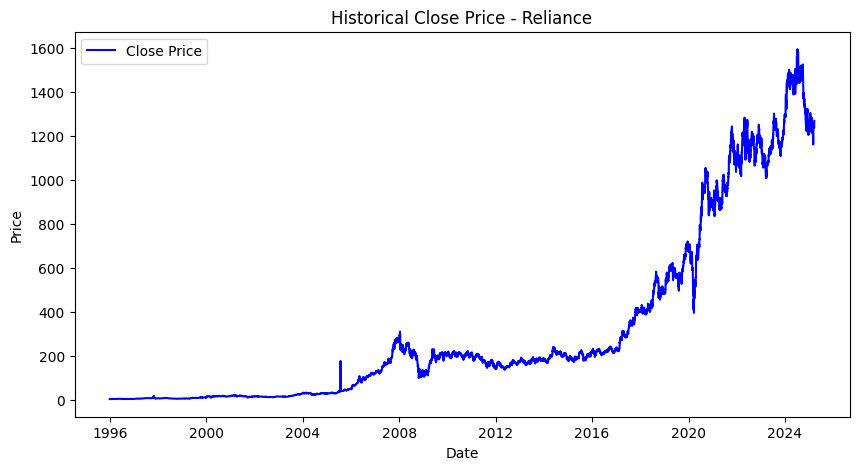

In [7]:
asset = 'Reliance'
df = data_dict[asset]

plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title(f'Historical Close Price - {asset}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

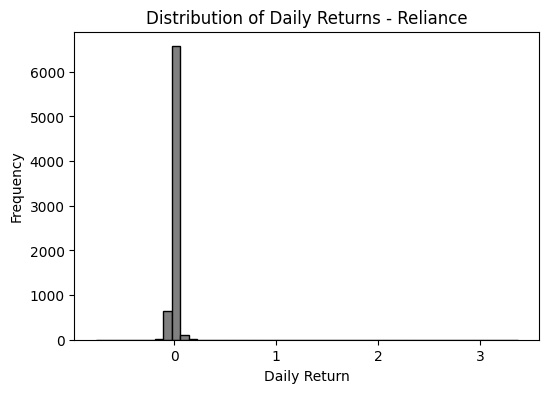

In [8]:
df['Daily_Return'] = df['Close'].pct_change()
plt.figure(figsize=(6, 4))
plt.hist(df['Daily_Return'].dropna(), bins=50, color='grey', edgecolor='black')
plt.title(f'Distribution of Daily Returns - {asset}')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()


Correlation Matrix:
            Open      High       Low     Close    Volume
Open    1.000000  0.999920  0.999910  0.999829 -0.299081
High    0.999920  1.000000  0.999889  0.999931 -0.298939
Low     0.999910  0.999889  1.000000  0.999927 -0.299093
Close   0.999829  0.999931  0.999927  1.000000 -0.298970
Volume -0.299081 -0.298939 -0.299093 -0.298970  1.000000


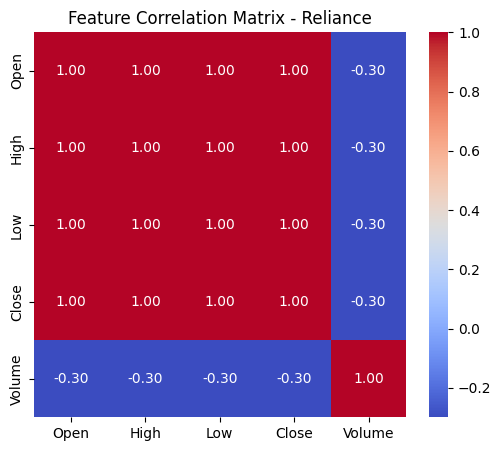

In [9]:
corr_matrix = df[['Open','High','Low','Close','Volume']].corr()
print("Correlation Matrix:")
print(corr_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Feature Correlation Matrix - {asset}')
plt.show()

In [10]:
def preprocess_lstm_data(df, feature='Close', time_steps=60):
    """
    Scale the data and create sequences of length `time_steps` to predict the next value.
    Returns X, y arrays and the fitted scaler.
    """
    data = df[[feature]].values  # shape: (n_samples, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i-time_steps:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y, scaler

In [11]:
time_window = 60
X_reliance, y_reliance, scaler_reliance = preprocess_lstm_data(data_dict['Reliance'], feature='Close', time_steps=time_window)
print("Reliance sequence data shape:", X_reliance.shape)

Reliance sequence data shape: (7277, 60, 1)


In [12]:
def build_lstm_model(time_steps, units1=128, units2=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Bidirectional(LSTM(units1, return_sequences=True), input_shape=(time_steps, 1)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(units2, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Display a model summary for Reliance
model_example = build_lstm_model(time_steps=time_window)
model_example.summary()


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,137 (1.14 MB)

 Trainable params: 298,369 (1.14 MB)

 Non-trainable params: 768 (3.00 KB)

In [13]:
def build_improved_lstm_model(time_steps, input_dim=1, 
                              units1=256, units2=128, units3=64, 
                              dropout_rate=0.3, learning_rate=0.0005):
    """
    Build a more complex stacked LSTM model.
    
    - The first two layers are Bidirectional LSTMs.
    - The third LSTM layer is unidirectional.
    - Dropout and BatchNormalization are applied after each LSTM layer.
    """
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
    from tensorflow.keras.optimizers import Adam
    
    model = Sequential()
    # First LSTM layer: Bidirectional with a high number of units
    model.add(Bidirectional(LSTM(units1, return_sequences=True), 
                            input_shape=(time_steps, input_dim)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Second LSTM layer: Bidirectional
    model.add(Bidirectional(LSTM(units2, return_sequences=True)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Third LSTM layer: unidirectional, reducing the sequence to a single output
    model.add(LSTM(units3, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    
    # Dense output layer for regression
    model.add(Dense(1))
    
    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

def train_and_evaluate_improved_model(asset_name, df, time_window=60):
    """
    Preprocess the data, train the improved LSTM model, and evaluate its performance.
    """
    # Preprocess the data (assumes a 'Close' column exists)
    X, y, scaler = preprocess_lstm_data(df, feature='Close', time_steps=time_window)
    
    # Split into train/validation/test sets (80/10/10 split)
    train_size = int(len(X) * 0.8)
    X_train, X_temp = X[:train_size], X[train_size:]
    y_train, y_temp = y[:train_size], y[train_size:]
    val_size = int(len(X_temp) * 0.5)
    X_val, X_test = X_temp[:val_size], X_temp[val_size:]
    y_val, y_test = y_temp[:val_size], y_temp[val_size:]
    
    # Build the improved model
    model = build_improved_lstm_model(time_steps=time_window, input_dim=1,
                                      units1=256, units2=128, units3=64, 
                                      dropout_rate=0.3, learning_rate=0.0005)
    
    # Train the model for more epochs to allow convergence
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                        validation_data=(X_val, y_val), verbose=1)
    
    # Evaluate the model on the test set
    predictions = model.predict(X_test)
    pred_prices = scaler.inverse_transform(predictions)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1,1))
    
    rmse = np.sqrt(mean_squared_error(actual_prices, pred_prices))
    mae = mean_absolute_error(actual_prices, pred_prices)
    mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100
    print(f"{asset_name} - Improved Model RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    
    return model, scaler, actual_prices, pred_prices

# Example usage: Train improved model for TCS
# (Assuming 'data_dict' has been populated with the processed DataFrames for each asset)
improved_model_tcs, scaler_tcs, actual_tcs, preds_tcs = train_and_evaluate_improved_model('TCS', data_dict['TCS'])


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - loss: 1.0231 - val_loss: 0.3197
Epoch 2/50
134/139 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.5473

KeyboardInterrupt: 

In [ ]:
tuner = Hyperband(
    build_lstm_model_tuner,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyperparam_tuning',
    project_name='stock_lstm_tuning'
)

In [ ]:
train_size = int(len(X_reliance) * 0.8)
X_train, X_temp = X_reliance[:train_size], X_reliance[train_size:]
y_train, y_temp = y_reliance[:train_size], y_reliance[train_size:]
val_size = int(len(X_temp) * 0.5)
X_val, X_test = X_temp[:val_size], X_temp[val_size:]
y_val, y_test = y_temp[:val_size], y_temp[val_size:]

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=1)
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters for Reliance:", best_hp.values)


Trial 30 Complete [00h 03m 13s]
val_loss: 0.01689278706908226

Best val_loss So Far: 0.00034796816180460155
Total elapsed time: 00h 32m 08s
Best hyperparameters for Reliance: {'num_layers': 2, 'units_layer1': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'units_layer2': 128, 'units_layer3': 32, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [ ]:
def train_and_evaluate_model(asset_name, df):
    # Preprocess data
    X, y, scaler = preprocess_lstm_data(df, feature='Close', time_steps=time_window)
    # Split into train/validation/test
    train_size = int(len(X) * 0.8)
    X_train, X_temp = X[:train_size], X[train_size:]
    y_train, y_temp = y[:train_size], y[train_size:]
    val_size = int(len(X_temp) * 0.5)
    X_val, X_test = X_temp[:val_size], X_temp[val_size:]
    y_val, y_test = y_temp[:val_size], y_temp[val_size:]
    
    # Retrieve tuned hyperparameters, or use defaults if not present
    units1 = best_hp.values.get('units_layer1', 128)
    units2 = best_hp.values.get('units_layer2', 64)
    dropout_rate = best_hp.values.get('dropout_rate', 0.2)
    learning_rate = best_hp.values.get('learning_rate', 0.001)
    
    # Build model using tuned hyperparameters
    model = build_lstm_model(time_steps=time_window,
                             units1=units1,
                             units2=units2,
                             dropout_rate=dropout_rate,
                             learning_rate=learning_rate)
    
    history = model.fit(X_train, y_train, 
                        epochs=20, batch_size=32, 
                        validation_data=(X_val, y_val),
                        verbose=0)
    
    predictions = model.predict(X_test)
    pred_prices = scaler.inverse_transform(predictions)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1,1))
    
    rmse = np.sqrt(mean_squared_error(actual_prices, pred_prices))
    mae = mean_absolute_error(actual_prices, pred_prices)
    mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100
    print(f"{asset_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    
    return model, scaler, actual_prices, pred_prices


trained_models = {}
scalers = {}
results = {}

for name, df in data_dict.items():
    print(f"\nTraining model for {name}...")
    model, scaler, actual, preds = train_and_evaluate_model(name, df)
    trained_models[name] = model
    scalers[name] = scaler
    results[name] = {'actual': actual, 'predicted': preds}


Training model for TCS...


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
TCS - RMSE: 263.34, MAE: 230.49, MAPE: 6.51%

Training model for Reliance...


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step
Reliance - RMSE: 842.56, MAE: 666.98, MAPE: 50.19%

Training model for HDFCBANK...


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
HDFCBANK - RMSE: 384.78, MAE: 316.14, MAPE: 19.35%

Training model for NIFTY_50...


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
NIFTY_50 - RMSE: 6398.80, MAE: 6315.26, MAPE: 26.41%

Training model for NIFTY_500...


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
NIFTY_500 - RMSE: 2227.94, MAE: 2151.75, MAPE: 9.61%

Training model for NIFTY_Bank...


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
NIFTY_Bank - RMSE: 3608.50, MAE: 3438.80, MAPE: 6.71%

Training model for NIFTY_FMCG...


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step
NIFTY_FMCG - RMSE: 7874.71, MAE: 7721.75, MAPE: 13.30%

Training model for NIFTY_IT...


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
NIFTY_IT - RMSE: 3866.77, MAE: 3450.77, MAPE: 8.23%

Training model for NIFTY_Midcap_100...


c:\Users\pande\anaconda3\envs\MachineLearning\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
NIFTY_Midcap_100 - RMSE: 6500.33, MAE: 6428.46, MAPE: 41.54%


In [ ]:
def forecast_future(model, scaler, last_sequence, n_steps):
    """
    Given a trained model, scaler, and the last sequence of data (shape: (time_steps, 1)),
    predict the next n_steps future values.
    """
    seq = last_sequence.copy()
    predictions = []
    for _ in range(n_steps):
        seq_scaled = scaler.transform(seq.reshape(-1, 1))
        X_input = seq_scaled.reshape(1, seq_scaled.shape[0], 1)
        y_pred_scaled = model.predict(X_input, verbose=0)
        y_pred = scaler.inverse_transform(y_pred_scaled)[0, 0]
        predictions.append(y_pred)
        seq = np.append(seq[1:], [[y_pred]], axis=0)
    return np.array(predictions)

In [ ]:
df_reliance = data_dict['Reliance']
last_seq = df_reliance[['Close']].values[-time_window:]
future_forecast = forecast_future(trained_models['Reliance'], scalers['Reliance'], last_seq, n_steps=30)
print("Next 30-day forecast for Reliance:\n", future_forecast)


Next 30-day forecast for Reliance:
 [1712.3616 1827.8181 1910.5499 2013.1239 2174.7026 2458.4778 2977.706
 3727.49   4182.1045 4329.2744 4449.2603 4549.626  4613.306  4652.8115
 4678.243  4696.8613 4710.8916 4716.802  4724.996  4742.5938 4762.211
 4774.99   4783.5547 4790.273  4795.349  4772.4624 4662.1694 4624.1113
 4623.7603 4625.4014]


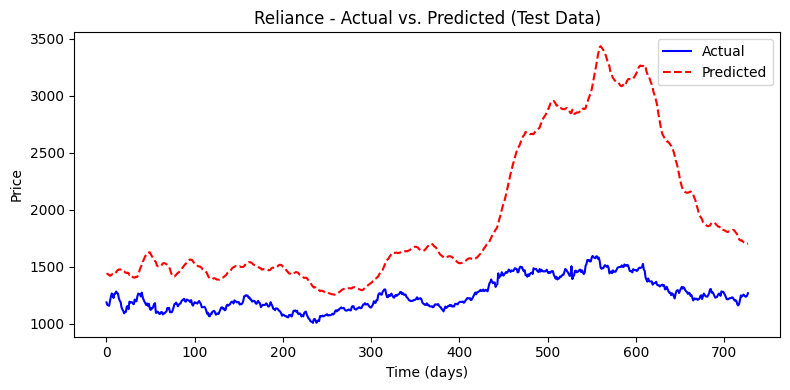

In [ ]:
asset = 'Reliance'
actual = results[asset]['actual']
pred = results[asset]['predicted']
plt.figure(figsize=(8,4))
plt.plot(actual, label='Actual', color='blue')
plt.plot(pred, label='Predicted', color='red', linestyle='--')
plt.title(f"{asset} - Actual vs. Predicted (Test Data)")
plt.xlabel('Time (days)')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

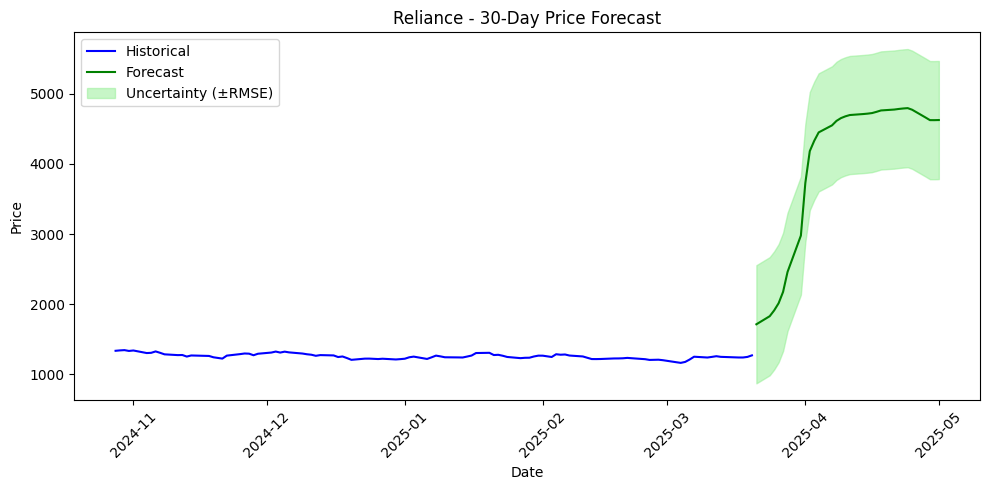

In [ ]:
history = df_reliance['Close'][-100:]  # Last 100 days for context
forecast = forecast_future(trained_models[asset], scalers[asset], df_reliance[['Close']].values[-time_window:], n_steps=30)
last_date = df_reliance.index[-1]
future_dates = pd.bdate_range(last_date, periods=31, freq='B')[1:]
forecast_series = pd.Series(forecast, index=future_dates)
rmse_val = np.sqrt(mean_squared_error(actual, pred))

plt.figure(figsize=(10,5))
plt.plot(history.index, history.values, label='Historical', color='blue')
plt.plot(future_dates, forecast, label='Forecast', color='green')
plt.fill_between(future_dates, forecast - rmse_val, forecast + rmse_val, color='lightgreen', alpha=0.5, label='Uncertainty (±RMSE)')
plt.title(f"{asset} - 30-Day Price Forecast")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

              Asset         RMSE          MAE       MAPE
0               TCS   263.340234   230.492476   6.513550
1          Reliance   842.559409   666.979438  50.188127
2          HDFCBANK   384.778323   316.142890  19.345391
3          NIFTY_50  6398.796468  6315.256856  26.409722
4         NIFTY_500  2227.938777  2151.746345   9.606143
5        NIFTY_Bank  3608.503696  3438.801056   6.712529
6        NIFTY_FMCG  7874.707296  7721.748438  13.299607
7          NIFTY_IT  3866.765914  3450.771282   8.232597
8  NIFTY_Midcap_100  6500.327964  6428.463136  41.538075


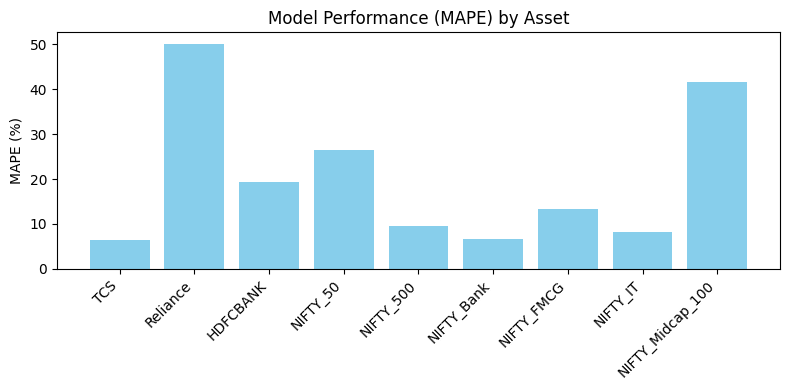

In [ ]:
metrics_summary = []
for name, res in results.items():
    actual = res['actual']
    pred = res['predicted']
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = np.mean(np.abs((actual - pred) / actual)) * 100
    metrics_summary.append([name, rmse, mae, mape])

metrics_df = pd.DataFrame(metrics_summary, columns=['Asset', 'RMSE', 'MAE', 'MAPE'])
print(metrics_df)

plt.figure(figsize=(8,4))
plt.bar(metrics_df['Asset'], metrics_df['MAPE'], color='skyblue')
plt.title('Model Performance (MAPE) by Asset')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
os.makedirs('models', exist_ok=True)
import pickle

for name, model in trained_models.items():
    model.save(f'models/{name}_LSTM_model.h5')
    with open(f'models/{name}_scaler.pkl', 'wb') as f:
        pickle.dump(scalers[name], f)
print("Models and scalers saved to 'models/' directory.")


Models and scalers saved to 'models/' directory.


In [ ]:
def load_model_and_scaler(asset_name):
    model = load_model(f'models/{asset_name}_LSTM_model.h5')
    with open(f'models/{asset_name}_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    return model, scaler

def predict_next_n_days(asset_name, recent_data, n_days=30):
    model, scaler = load_model_and_scaler(asset_name)
    return forecast_future(model, scaler, recent_data, n_days)

# Example usage: Predict next 5 days for Reliance
recent_seq = df_reliance[['Close']].values[-time_window:]
predicted_next_5 = predict_next_n_days('Reliance', recent_seq, n_days=5)
print("Next 5-day prediction for Reliance:", predicted_next_5)

Next 5-day prediction for Reliance: [1712.3616 1827.8181 1910.5499 2013.1239 2174.7026]
